## Calc VC bound

In [1]:
import numpy as np 

def vc_bound(N, dvc, epsilon):
    """
    vc bound for "BAD EVENT", the probability of |E_in - E_out| > epsilon
    
    Args:
        N: int, sample size
        dvc: int, the vc dimension of the hypothesis set 
        epsilon: float, error
    Returns:
        VC bound
    """
    return 4 * (2*N)** dvc * np.exp(-1/8 * epsilon**2 * N)

In [2]:
N = 10_000
d_vc = 10
epsilon = 0.05
delta = 0.05  # delta = 1 - confidence

while vc_bound(N, d_vc, epsilon) > delta:
    N += 10_000
print(N)

460000


## different bounds

In [3]:
def origin_vc_bound(N, delta, d_vc):
    return np.sqrt(8/N * np.log((4. * (2 * N) ** d_vc)/delta))

def rademacher_penalty_bound(N, delta, d_vc):
    return np.sqrt(2/N * np.log(2.*N * N ** d_vc)) + np.sqrt(2/N * np.log(1./delta)) + 1/N

def parrondo_and_Van(N, delta, d_vc):
    def Delta(N, delta, d_vc):
        return 4/N**2 + 4/N * (np.log(6/delta) + d_vc * np.log(2 * N))
#     print("Delta=", Delta(N, delta, d_vc))
    return 1/N + 1/2 * np.sqrt(Delta(N, delta, d_vc)) 

def devroye(N, delta, d_vc):
    def Delta(N, delta, d_vc):
        return 4/N**2 + (1 - 2/N) * 2/N * (np.log(4/delta) + 2 * d_vc * np.log(N))
#     print("Delta=", Delta(N, delta, d_vc))
    return (2/N + np.sqrt(Delta(N, delta, d_vc))) / (2 * (1 - 2/N))

def variant_vc_bound(N, delta, d_vc):
    return np.sqrt(16/N * np.log(2. * N ** d_vc / np.sqrt(delta)))

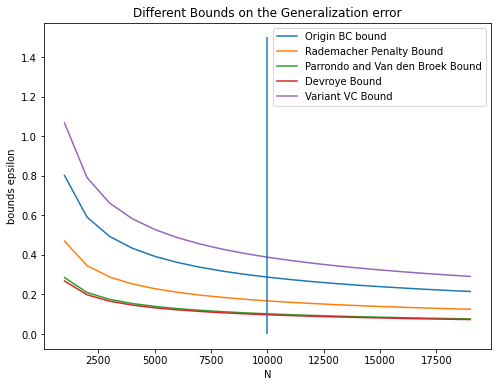

In [4]:
import matplotlib.pyplot as plt 

dvc = 50
delta = 0.05 
fig, ax = plt.subplots(1, 1, figsize=(8,6))
Ns = range(1_000, 20_000, 1_000)

ax.plot(Ns, [origin_vc_bound(N, delta, d_vc) for N in Ns], label='Origin BC bound')
ax.plot(Ns, [rademacher_penalty_bound(N, delta, d_vc) for N in Ns], label='Rademacher Penalty Bound')
ax.plot(Ns, [parrondo_and_Van(N, delta, d_vc) for N in Ns], label='Parrondo and Van den Broek Bound')
ax.plot(Ns, [devroye(N, delta, d_vc) for N in Ns], label='Devroye Bound')
ax.plot(Ns, [variant_vc_bound(N, delta, d_vc) for N in Ns], label='Variant VC Bound')

ax.set_title("Different Bounds on the Generalization error")
ax.set_xlabel("N")
ax.set_ylabel("bounds epsilon")
ax.vlines(x=10000, ymin=0, ymax=1.5)
ax.legend();

In [5]:
print(devroye(10000, 0.05, 50))
print(parrondo_and_Van(10000, 0.05, 50))

0.21522804980824667
0.2236982936807856


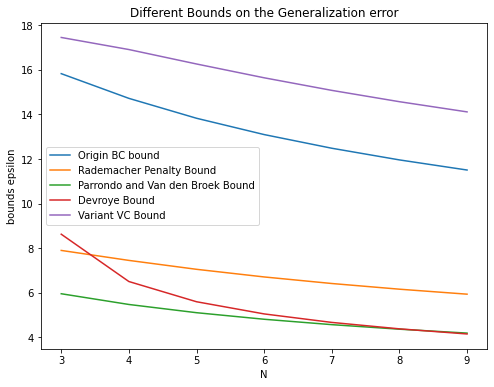

In [6]:
d_vc = 50
delta = 0.05

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
Ns = range(3, 10, 1)

ax.plot(Ns, [origin_vc_bound(N, delta, d_vc) for N in Ns], label='Origin BC bound')
ax.plot(Ns, [rademacher_penalty_bound(N, delta, d_vc) for N in Ns], label='Rademacher Penalty Bound')
ax.plot(Ns, [parrondo_and_Van(N, delta, d_vc) for N in Ns], label='Parrondo and Van den Broek Bound')
ax.plot(Ns, [devroye(N, delta, d_vc) for N in Ns], label='Devroye Bound')
ax.plot(Ns, [variant_vc_bound(N, delta, d_vc) for N in Ns], label='Variant VC Bound')

ax.set_title("Different Bounds on the Generalization error")
ax.set_xlabel("N")
ax.set_ylabel("bounds epsilon")
ax.legend();

## Decision Stump Algorithm

In [24]:
def generateXY(n):
    """
    Generate a data set (x,y) with size n by
    (a) Generate x by a uniform distribution in [-1, 1];
    (b) Generate y by f(x) = sign(x) plus noise, 
        where the noise flips the result with 20%
        probability.
        
    Args:
        n: int, size of data set to generate
    Returns:
        data: numpy array, n x 2, result data set
    """
    x = np.random.uniform(low=-1, high=1, size=n)
    y = noisy_vec(np.sign(x))
    data = np.c_[x,y]

    return data 

def noisy(y):
    r = np.random.rand()
    if r < 0.2:
        y = -y 
    return y

noisy_vec = np.vectorize(noisy)

In [28]:
def decision_stump(X, y):
    """
    Decision stump algorithm. Choose the lowest Ein among all 2N possible cases.
    Args:
        X: numpy array(n, )
        y: numpy array(n, )
    Returns:
        min_Ein: double
        theta_best: double
        s_best: int, +1 or -1
    """
    n = X.shape[0]
    sorted_idx = np.argsort(X)
    X = X[sorted_idx]
    y = y[sorted_idx]

    min_Ein = np.inf 
    best_theta = None 
    best_s = None 

    for i in range(n-1):
        theta = (X[i] + X[i+1]) / 2 
        for s in (-1, +1):
            Ein = calc_Ein(X, y, s, theta)
            if Ein < min_Ein:
                min_Ein = Ein
                best_s = s 
                best_theta = theta
            
    return min_Ein, best_theta, best_s

def calc_Ein(X, y, s, theta):
    return np.mean(s*np.sign(X-theta) != y)

def calc_Eout(s, theta):
    return 0.5 + 0.3 * s * (abs(theta) - 1)

In [29]:
Ein_lst = []
Eout_lst = []
for _ in range(5000):
    data = generateXY(20)
    X, y = data[:, 0], data[:, 1]
    Ein, theta, s = decision_stump(X, y)
    Eout = calc_Eout(s, theta)
    Ein_lst.append(Ein)
    Eout_lst.append(Eout)

In [31]:
print(f"Average of Ein:{np.mean(Ein_lst)}")

Average of Ein:0.17193999999999998


In [32]:
print(f"Average of Eout:{np.mean(Eout_lst)}")

Average of Eout:0.2579076188756907


## Decision stump for multi-dimension data

In [34]:
def multi_decision_stump(X, y):
    """
    Choose the dimension with the lowest Ein to classify data.
    
    Args:
        X: numpy array (n, d)
        y: numpy array (n, )
        
    Returns:
        min_Ein   : double
        theta_best: double
        s_best    : int, +1 or -1
        dim_best  : int starts with 1, dimension with the lowest Ein
    """
    _, d = X.shape
    min_Ein = np.inf 
    best_theta = None 
    best_s = None 
    best_dim = None 
    
    for i in range(d):
        X_i = X[:, i]
        Ein, theta, s = decision_stump(X_i, y)
        if Ein < min_Ein:
            min_Ein = Ein 
            best_theta = theta 
            best_s = s 
            best_dim = i + 1 
    
    return min_Ein, best_theta, best_s, best_dim

In [35]:
import pandas as pd 

train_data = pd.read_csv("hw2_train.dat.txt", sep="\s+", header=None)
test_data = pd.read_csv("hw2_test.dat.txt", sep="\s+", header=None)

In [37]:
X_train = train_data.iloc[:, :-1].to_numpy()
y_train = train_data.iloc[:, -1].to_numpy()

X_test = test_data.iloc[:, :-1].to_numpy()
y_test = test_data.iloc[:, -1].to_numpy()

In [38]:
min_Ein, best_theta, best_s, best_dim = multi_decision_stump(X_train, y_train)
print(f"Optimal Ein: {min_Ein}")

Optimal Ein: 0.25


In [39]:
X_test_dim = X_test[:, best_dim-1]
E_test = calc_Ein(X_test_dim, y_test, best_s, best_theta)
print(E_test)

0.355
